<a href="https://colab.research.google.com/github/smojumder018/SUPREME/blob/main/Vision_Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Vision Transformer Tutorial: Predicting Stress from composite material images**

## **Introduction**

Transformers and their Attention blocks are designed to handle sequential data by shaprpening a models focus on relevent details of a sequintial input. In this tutorial, we apply a transformer architecture to predict stress required to stretch a given composite based on FEM microstructure images, which will be *Patchified* to produce a sequence.

---

## **Problem Statement**

We are given a dataset containing:

- **Microstructure Images:** Material composition of two materials  
- **Stress (MPa):** Applied mechanical force  
- **Strain:** Material deformation (target to predict)

For each volume fraction, we observe a stress–strain curve, which we treat as a time-like sequence. Our objectives are:

1. **Patchify the Image** to produce a transformer applicable sequence
2. **Feed into Attention Blocks within transformer framework** to extract information about relevent microstucture in latent dimension
4. **FFNN** to go from latent dimension information to final stress-strain curve prediction
3. **Visualize predicted vs. true stress–strain curves** to understand how well it performed

In [ ]:
# Mount your Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
#from scipy.io import loadmat
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import re
import torch
from torch.utils.data import TensorDataset, DataLoader

# Set up the device (use GPU if available, otherwise fallback to CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


Found 240 text files in /content/drive/MyDrive/Colab_Notebooks/Transformers/Micro_results: ['result_1_10_1.txt', 'result_1_10_2.txt', 'result_1_10_3.txt', 'result_1_10_4.txt', 'result_1_10_5.txt', 'result_1_10_6.txt', 'result_1_11_1.txt', 'result_1_11_2.txt', 'result_1_11_3.txt', 'result_1_11_4.txt', 'result_1_11_5.txt', 'result_1_11_6.txt', 'result_1_12_1.txt', 'result_1_12_2.txt', 'result_1_12_3.txt', 'result_1_12_4.txt', 'result_1_12_5.txt', 'result_1_12_6.txt', 'result_1_13_1.txt', 'result_1_13_2.txt', 'result_1_13_3.txt', 'result_1_13_4.txt', 'result_1_13_5.txt', 'result_1_13_6.txt', 'result_1_14_1.txt', 'result_1_14_2.txt', 'result_1_14_3.txt', 'result_1_14_4.txt', 'result_1_14_5.txt', 'result_1_14_6.txt', 'result_1_15_1.txt', 'result_1_15_2.txt', 'result_1_15_3.txt', 'result_1_15_4.txt', 'result_1_15_5.txt', 'result_1_15_6.txt', 'result_1_16_1.txt', 'result_1_16_2.txt', 'result_1_16_3.txt', 'result_1_16_4.txt', 'result_1_16_5.txt', 'result_1_16_6.txt', 'result_1_17_1.txt', 'resu

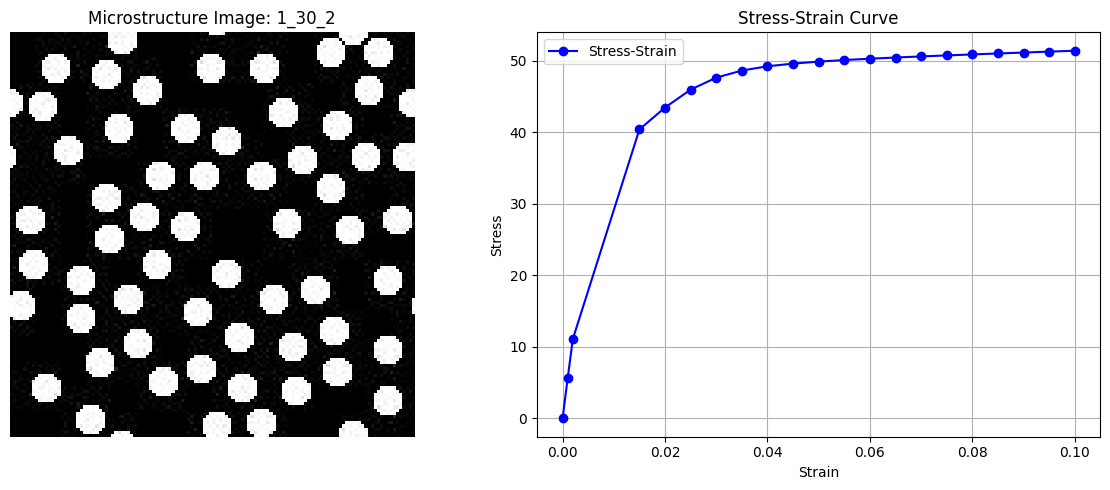

In [ ]:


def preprocess_data(txt_folder, image_folder, test_size=0.15):

    file_mapping = {}

    txt_files = sorted([f for f in os.listdir(txt_folder) if f.endswith('.txt')])
    print(f"Found {len(txt_files)} text files in {txt_folder}: {txt_files}")
    for filename in txt_files:
        match = re.search(r'(\d+_\d+_\d+)(?=\.\w+$)', filename)

        if match:
            identifier = match.group(1)
            txt_path = os.path.join(txt_folder, filename)

            try:
                data = pd.read_csv(txt_path, delimiter='\t', header=None).values.flatten()
            except Exception as e:
                print(f"Error loading {filename}: {e}")
                continue

            strain = data[::2]
            stress = data[1::2]

            data_normalized = np.column_stack((strain, stress))

            image_filename = f"vf_{identifier}.jpg"
            image_path = os.path.join(image_folder, image_filename)

            try:
                image = mpimg.imread(image_path)
                file_mapping[identifier] = {
                    'data': data_normalized,
                    'image': image
                }
            except Exception as e:
                print(f"Error loading image file {image_filename}: {e}")


    print(f"Total valid identifiers found: {len(file_mapping)}")

    if len(file_mapping) == 0:
        raise ValueError("No valid data was found to split.")

    identifiers = list(file_mapping.keys())
    train_ids, val_ids = train_test_split(identifiers, test_size=test_size, random_state=42)

    train_data = [file_mapping[id]['data'] for id in train_ids]
    train_images = [file_mapping[id]['image'] for id in train_ids]
    val_data = [file_mapping[id]['data'] for id in val_ids]
    val_images = [file_mapping[id]['image'] for id in val_ids]

    return np.array(train_data), np.array(train_images), np.array(val_data), np.array(val_images), file_mapping

def display_data_and_image(identifier, file_mapping):
    if identifier not in file_mapping:
        print(f"Identifier '{identifier}' not found in file_mapping.")
        return

    image = file_mapping[identifier]['image']
    data = file_mapping[identifier]['data']

    if image is None or data is None:
        print("Error: Image or data is missing!")
        return

    data = np.array(data).reshape(21, 2)
    sorted_indices = np.argsort(data[:, 0])
    sorted_data = data[sorted_indices]

    strain = sorted_data[:, 0]
    stress = sorted_data[:, 1]

    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    ax[0].imshow(image, cmap='gray', interpolation='nearest')
    ax[0].set_title(f"Microstructure Image: {identifier}")
    ax[0].axis('off')

    ax[1].plot(strain, stress, marker='o', linestyle='-', color='b', label="Stress-Strain")
    ax[1].set_xlabel("Strain")
    ax[1].set_ylabel("Stress")
    ax[1].set_title("Stress-Strain Curve")
    ax[1].legend()
    ax[1].grid(True)

    plt.tight_layout()
    plt.show()

# Path to your Burgers.npz file inside your Google Drive

# # Define paths
txt_folder = '/content/drive/MyDrive/SUPREME/Transformer/Micro_results'
image_folder = '/content/drive/MyDrive/SUPREME/Transformer/micro_images'
txt_folder = '/content/drive/MyDrive/Colab_Notebooks/Transformers/Micro_results'
image_folder = '/content/drive/MyDrive/Colab_Notebooks/Transformers/micro_images'

# # Run preprocessing
train_data, train_images, val_data, val_images, file_mapping = preprocess_data(txt_folder, image_folder)

###TEST
import torch
from torch.utils.data import TensorDataset, DataLoader

# Convert images to torch tensors with shape (B, 1, H, W)
train_images_tensor = torch.tensor(train_images, dtype=torch.float32).unsqueeze(1)
val_images_tensor   = torch.tensor(val_images, dtype=torch.float32).unsqueeze(1)

# Convert stress-strain data to shape (B, 42) for regression target
train_data_tensor = torch.tensor(train_data, dtype=torch.float32).reshape(-1, 42)
val_data_tensor   = torch.tensor(val_data, dtype=torch.float32).reshape(-1, 42)


train_dataset = TensorDataset(train_images_tensor, train_data_tensor)
val_dataset   = TensorDataset(val_images_tensor, val_data_tensor)

batch_size = 4

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)




identifier = '1_30_2'
display_data_and_image(identifier, file_mapping)

In [ ]:
import torch.nn as nn
import torch
import einops

from einops import rearrange
from einops.layers.torch import Rearrange

import random
import h5py
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt

from torch.optim import AdamW

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

***Model Overview***
1. Split image into patches → embeddings E₀
2. Add positional info → E₁
3. For each of L layers:
     a. Eᵢ ← Eᵢ + Attention(Eᵢ)
     b. Eᵢ ← Eᵢ + FFN(Eᵢ)
4. Flatten E_L → vector → MLP → stress[21]


In [ ]:
# Appplies following operations:
# 1. LayerNorm
# 2. nn.Linear (dim --> hidden_dim)
# 3. GELU
# 4. Dropout
# 5. nn.Linear (hidden_dim --> dim)
# 6. Dropout

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)


**We need Attention:**  
Imagine each patch has a “question” (Queary) and an “answer”(Value). Attention lets every patch ask *which other patches* have the answers it needs, then gather those answers in a weighted mix. These are based on the local microstructure in each patch, or connotations of words in a sentance.

---

### What → Why → How

| **What**                                   | **Why**                                                          | **How (in code)**                                      |
|--------------------------------------------|------------------------------------------------------------------|---------------------------------------------------------|
| **QKV projection**                         | Create three views of each embedding: queries, keys, and values | ```python
qkv = linear_qkv(x)          # x: [b, n, dim] → [b, n, 3*dim]
q, k, v = qkv.chunk(3, dim=-1)
``` |
| **Scaled‐dot product**                     | Compute raw attention scores                                     | ```python
scores = (q @ k.transpose(-2,-1)) / sqrt(dim_head)
attn   = softmax(scores, dim=-1)            # [b, heads, n, n]
``` |
| **Weighted sum of values**                 | Aggregate information from all patches                           | ```python
out = attn @ v                              # [b, heads, n, dim_head]
out = rearrange(out, 'b h n d -> b n (h d)')
out = linear_out(out)                       # project back to `dim`
``` |


In [ ]:
# Takes a sequence of embedding of dimension dim
# 1. Applies LayerNorm
# 2. Applies linear layer dim -> 3x inner_dim
#                                NOTE: inner_dim = dim_head x heads
# 3. Applies attention
# 4. Projects inner -> dim

class AttentionBlock(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.norm = nn.LayerNorm(dim)

        self.attend = nn.Softmax(dim = -1)
        self.dropout = nn.Dropout(dropout)

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
      # LayerNorm: normalize inputs before attention
      x = self.norm(x)

      # QKV projection: map embeddings to queries, keys, values
      qkv = self.to_qkv(x).chunk(3, dim=-1)
      # Split each into 'heads' for parallel attention subspaces
      q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=self.heads), qkv)

      # Scaled dot-product: compute raw attention scores, scale by √d_head
      dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

      # Softmax attention weights + dropout for regularization
      attn = self.attend(dots)
      attn = self.dropout(attn)

      # Weighted sum of values: aggregate patch information
      out = torch.matmul(attn, v)
      # Recombine heads: flatten head and feature dims back to model dim
      out = rearrange(out, 'b h n d -> b n (h d)')
      # Final linear projection to output embedding
      return self.to_out(out)


***Transformer Block**
Imagine you have a panel of experts (patch embeddings). Each expert first **talks** to the others to gather insights (Attention), then goes off to **think** on its own about what it heard (Feed-Forward Network), and finally you gather all their refined opinions. You put together H heads and repeat the process D times (depth).

In [ ]:
# Takes sequence of embeddings of dimension dim
# 1. Applies depth times:
#    a) Attention block: dim->dim (in the last dimension)
#    b) MLP block:       dim->dim (in the last dimension)
# 2. Applies LayerNorm

class TransformerBlock(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim):
        super().__init__()
        # Final normalization after all blocks (see "Final LayerNorm" above)
        self.norm = nn.LayerNorm(dim)

        # Create a list of [Attention, FFN] pairs, repeated 'depth' times
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                AttentionBlock(dim, heads=heads, dim_head=dim_head),  # "talk" step
                FeedForward(dim, mlp_dim)                             # "think" step
            ]))

    def forward(self, x):
        # Iterate through each [attention, ff] layer pair
        for attn, ff in self.layers:
            x = attn(x) + x   # attention + residual (see row 1 in table)
            x = ff(x) + x     # FFN + residual (see row 2 in table)
        return self.norm(x)   # final LayerNorm (stabilization)

def pair(t):
    # If t is a single int, returns (t, t); otherwise returns t unchanged
    return t if isinstance(t, tuple) else (t, t)


## Vision Transformer (ViT)

### Patchify & Embed (“Experts Arrive”)
- Split the $H\times W$ image into $\frac{H}{P}\times\frac{W}{P}$ patches of size $P\times P$.  
- Flatten each patch and project it to a `dim`-dimensional vector (our “expert’s résumé”).  
- **LayerNorm** before/after the linear layer ensures stable, comparable embeddings.

### Positional Encoding (“Where They Sit”)
- Add a learnable embedding to each patch vector so the model knows *which* expert is in *which* seat.  
- Apply a small **Dropout** to regularize these position signals.

### Transformer Stack (“Talk & Think” × D)
For each of the `depth` layers:
1. **Attention (“Talk”)**  
   - Every patch-expert queries and hears from all others (multi-head, global context).  
2. **Residual Add**  
   - Keep an identity path so no “expert” gets lost if attention isn’t helpful.  
3. **Feed-Forward (“Think”)**  
   - Each patch-expert independently refines its understanding via a tiny MLP.  
4. **Residual Add**  
   - Again, preserve the option to skip if unneeded.  
- A **final LayerNorm** stabilizes the combined result.

### Latent Identity (“Pass-Through”)
- An `Identity` layer that does nothing by default but can be swapped out if you need direct access to the raw transformer output.

### MLP Head (“Summarize & Predict”)
- Flatten all final patch embeddings into one long vector.  
- Two-layer MLP (with GELU) that distills the global information into a 21-dimensional stress prediction (one stress value at each fixed strain).

### Utilities & Diagnostics
- `print_size()` reports the total parameter count—useful for gauging model scale and training requirements.

> **Metaphor Reminder:**  
> “Each patch is an expert. In each of D layers, they first **talk** (Attention) to share insights, then **think** (FFN) on their own, and finally we **summarize** all their wisdom into a stress curve.”


In [ ]:


class ViT(nn.Module):
    def __init__(self,
                 image_size,
                 patch_size,
                 dim,
                 depth,
                 heads,
                 mlp_dim=256,
                 channels=1,
                 dim_head=32,
                 emb_dropout=0.,
                 output_dim=21):  # 21 x 2
        super().__init__()

        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patch_height, p2=patch_width),
            nn.LayerNorm(patch_dim),
            nn.Linear(patch_dim, dim),
            nn.LayerNorm(dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = TransformerBlock(dim, depth, heads, dim_head, mlp_dim)

        self.to_latent = nn.Identity()

        # MLP head to predict stress vector (21 x 1 = 21 values)
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Flatten(),
            nn.Linear(num_patches * dim, 128),
            nn.GELU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape
        x += self.pos_embedding[:, :n]
        x = self.dropout(x)
        x = self.transformer(x)
        x = self.to_latent(x)
        return self.mlp_head(x)

    def print_size(self):
        nparams = sum(p.numel() for p in self.parameters())
        print(f'Total number of model parameters: {nparams}')
        return nparams


### Model Assembly


In [ ]:

# Initialize Vision Transformer for stress prediction
model = ViT(
    image_size   = 128,   # Input image height & width (HxW); must match your dataset images
    patch_size   = 16,    # Each patch is 16×16 pixels; image_size % patch_size == 0
    dim          = 64,    # Embedding dimension (model “width”); larger → more capacity, slower
    depth        = 4,     # Number of Transformer layers (stack depth); more → deeper model
    heads        = 4,     # Number of attention heads per layer; more → more parallel contexts
    mlp_dim      = 64,    # Hidden size in the FFN sub-layer; controls per-token nonlinearity
    channels     = 1,     # Number of input channels (1 = grayscale, 3 = RGB, etc.)
    dim_head     = 32,    # Dimension of each attention head; heads * dim_head should ≈ dim
    emb_dropout  = 0.0,   # Dropout rate after patch embedding (helps prevent overfitting)
    output_dim   = 21     # Final output size: one stress value per fixed strain location
)
# Model is now ready to train—tweak these hyperparameters to balance accuracy, speed, and overfitting risk.

model.print_size()



Total number of model parameters: 714197


714197

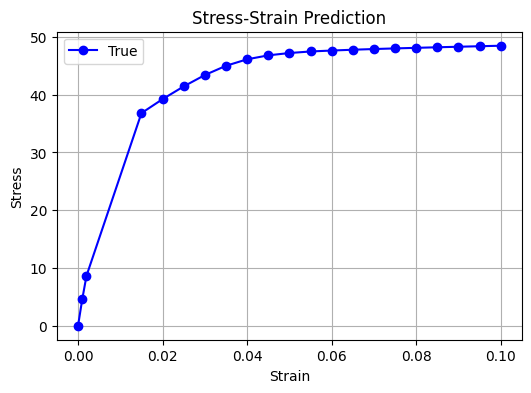

In [ ]:

# Get a batch from the val_loader
input_batch, output_batch = next(iter(val_loader))  # Unpack images and targets

# Get model prediction for this batch
pred_batch = model(input_batch)

# For visualization, pick the first sample in the batch
true = output_batch[0].reshape(21, 2).detach().cpu().numpy()
#predicted = pred_batch[0].reshape(21, 2).detach().cpu().numpy()

strain_true, stress_true = true[:, 0], true[:, 1]
#strain_pred, stress_pred = predicted[:, 0], predicted[:, 1]

plt.figure(figsize=(6, 4))
plt.plot(strain_true, stress_true, 'b-o', label='True')
#plt.plot(strain_pred, stress_pred, 'r--x', label='Predicted')
plt.xlabel('Strain')
plt.ylabel('Stress')
plt.title('Stress-Strain Prediction')
plt.legend()
plt.grid(True)
plt.show()




In [ ]:
optimizer = AdamW(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0 = 200, eta_min=10**-6)
l = nn.L1Loss()

epoch = 50

freq_print = 1
alpha = 1.0
beta = 0.5



for e in range(epoch):
    # — Training —
    model.train()
    train_mse = 0.0

    for step, (input_batch, output_batch) in enumerate(train_loader):
        optimizer.zero_grad()

        # forward: model now returns [B, 21] stress predictions
        preds = model(input_batch)             # [B, 21]
        B = preds.size(0)

        # extract ground-truth stress: reshape [B,42]→[B,21,2] and take index 1
        stress_gt = output_batch.view(B, 21, 2)[..., 1]  # [B, 21]

        # compute stress-only L1 loss
        loss_f = l(preds, stress_gt)

        loss_f.backward()
        optimizer.step()

        train_mse += loss_f.item()

    train_mse /= len(train_loader)

    # step LR scheduler
    scheduler.step()

    # — Validation —
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for step, (input_batch, output_batch) in enumerate(val_loader):
            preds = model(input_batch)           # [B, 21]
            stress_gt = output_batch.view(B, 21, 2)[..., 1]
            val_loss += l(preds, stress_gt).item()

    val_loss /= len(val_loader)

    # print status
    if e % freq_print == 0:
        lr = optimizer.param_groups[0]['lr']
        print(f"## Epoch: {e}  ## Train Loss: {train_mse:.4f}  ## Val Loss: {val_loss:.4f}  LR: {lr:.6f}")

## Epoch: 0  ## Train Loss: 9.9335  ## Val Loss: 1.4137  LR: 0.001000
## Epoch: 1  ## Train Loss: 1.0222  ## Val Loss: 0.9115  LR: 0.001000
## Epoch: 2  ## Train Loss: 1.2044  ## Val Loss: 1.0795  LR: 0.000999
## Epoch: 3  ## Train Loss: 0.9406  ## Val Loss: 0.7824  LR: 0.000999
## Epoch: 4  ## Train Loss: 0.9860  ## Val Loss: 1.0391  LR: 0.000998
## Epoch: 5  ## Train Loss: 0.8367  ## Val Loss: 0.9364  LR: 0.000998
## Epoch: 6  ## Train Loss: 0.7062  ## Val Loss: 0.8692  LR: 0.000997
## Epoch: 7  ## Train Loss: 0.7030  ## Val Loss: 0.8467  LR: 0.000996
## Epoch: 8  ## Train Loss: 0.7001  ## Val Loss: 1.5682  LR: 0.000995
## Epoch: 9  ## Train Loss: 0.6907  ## Val Loss: 0.7338  LR: 0.000994
## Epoch: 10  ## Train Loss: 0.7756  ## Val Loss: 1.3368  LR: 0.000993
## Epoch: 11  ## Train Loss: 0.6635  ## Val Loss: 1.0209  LR: 0.000991
## Epoch: 12  ## Train Loss: 0.7613  ## Val Loss: 0.7211  LR: 0.000990
## Epoch: 13  ## Train Loss: 0.7529  ## Val Loss: 0.8278  LR: 0.000988
## Epoch: 14  ##

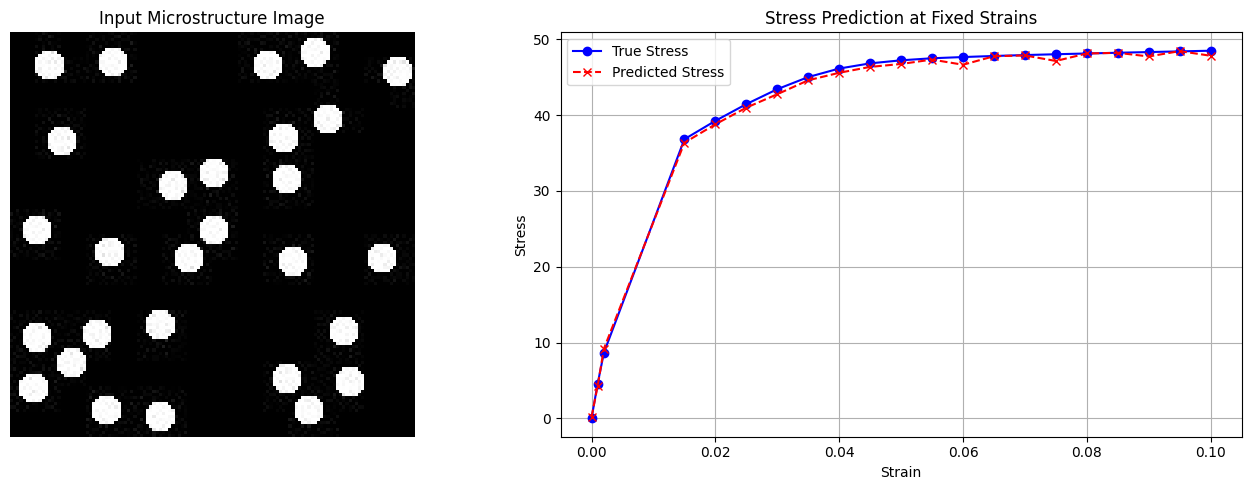

In [ ]:
# === Visualize stress predictions at fixed strain locations ===

# Fetch a batch
input_batch, output_batch = next(iter(val_loader))

model.eval()
with torch.no_grad():
    # pred_batch: [B, 21] stress values only
    pred_batch = model(input_batch)

# Take first sample
input_img    = input_batch[0, 0].cpu().numpy()      # [H, W]
true_vec     = output_batch[0].cpu().numpy()        # [42]

# Extract ground-truth strains and stresses
true_data    = true_vec.reshape(21, 2)              # [21, 2]
strain_true  = true_data[:, 0]                      # [21]
stress_true  = true_data[:, 1]                      # [21]

# Extract predicted stresses
stress_pred  = pred_batch[0].cpu().numpy()          # [21]

import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))

# Show input image
plt.subplot(1, 2, 1)
plt.imshow(input_img, cmap="gray")
plt.title("Input Microstructure Image")
plt.axis('off')

# Plot stress at each fixed strain
plt.subplot(1, 2, 2)
plt.plot(strain_true, stress_true, 'b-o', label='True Stress')
plt.plot(strain_true, stress_pred, 'r--x', label='Predicted Stress')
plt.xlabel('Strain')
plt.ylabel('Stress')
plt.title('Stress Prediction at Fixed Strains')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
